# Combined Analysis

Let's simply merge the CC'd corrected matrices from the seperate analyses and see how things cluster.

In [137]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
ad_ctr = sc.read_10x_mtx(
    './sources/ctr',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)

ad_ctr.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

ad_sin = sc.read_10x_mtx(
    './sources/siN6amt1',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)

ad_sin.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

In [4]:
ad_combi = ad_ctr.concatenate(ad_sin, join="outer", batch_key="SIN")
ad_combi
# Using 'outer' gave errors (due to NaN's?), 829 is still okay for clustering.

AnnData object with n_obs × n_vars = 8224 × 33694 
    obs: 'SIN'
    var: 'gene_ids-0', 'gene_ids-1'

In [1]:
# phew!
import gc
gc.collect()

5

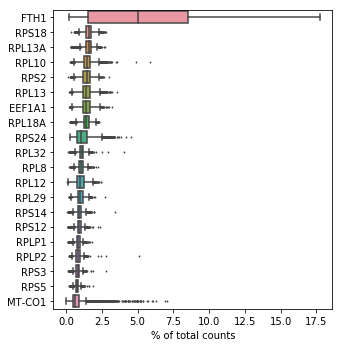

In [5]:
sc.pl.highest_expr_genes(ad_combi, n_top=20)

In [6]:
sc.pp.filter_cells(ad_combi, min_genes=200)
sc.pp.filter_genes(ad_combi, min_cells=3)

In [7]:
ad_combi

AnnData object with n_obs × n_vars = 8224 × 19962 
    obs: 'SIN', 'n_genes'
    var: 'gene_ids-0', 'gene_ids-1', 'n_cells'

In [8]:
def calcMito(obj):
    mito_genes = obj.var_names.str.startswith('MT-')
    # for each cell compute fraction of counts in mito genes vs. all genes
    # the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
    obj.obs['percent_mito'] = np.sum(obj[:, mito_genes].X, axis=1).A1 / np.sum(obj.X, axis=1).A1
    # add the total counts per cell as observations-annotation to adata
    obj.obs['n_counts'] = obj.X.sum(axis=1).A1
    
calcMito(ad_combi)

In [9]:
sc.pl.violin(ad_combi, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)

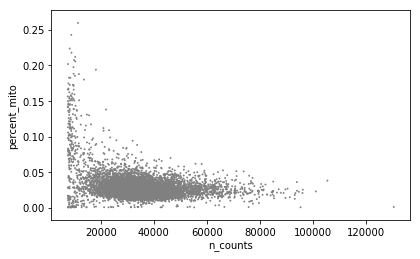

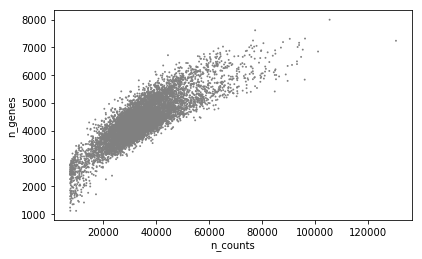

In [10]:
sc.pl.scatter(ad_combi, x='n_counts', y='percent_mito')
sc.pl.scatter(ad_combi, x='n_counts', y='n_genes')

In [11]:
ad_combi = ad_combi[ad_combi.obs['n_genes'] < 7000, :]
ad_combi = ad_combi[ad_combi.obs['n_counts'] < 80000, :]   # Filter
ad_combi = ad_combi[ad_combi.obs['percent_mito'] < 0.05, :]

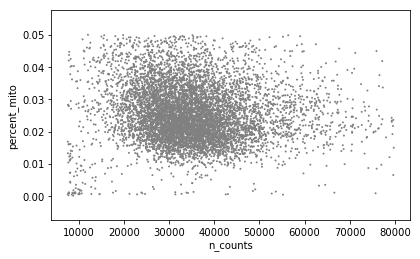

In [12]:
sc.pl.scatter(ad_combi, x='n_counts', y='percent_mito')
sc.pl.scatter(ad_combi, x='n_counts', y='n_genes')

In [13]:
# We need to re-normalize our cells due to the different batches
sc.pp.normalize_per_cell(ad_combi, counts_per_cell_after=1e4)

In [14]:
sc.pp.log1p(ad_combi)

In [15]:
ad_combi.raw = ad_combi

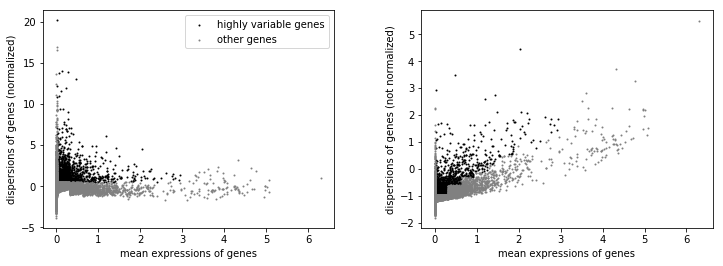

In [16]:
sc.pp.highly_variable_genes(ad_combi, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(ad_combi)

In [17]:
ad_combi = ad_combi[:, ad_combi.var['highly_variable']]
sc.pp.regress_out(ad_combi, ['n_counts', 'percent_mito'])

In [18]:
sc.pp.scale(ad_combi, max_value=10)

In [19]:
ad_combi.write("checkpoints/scanpy.combi.h5ad")

# Clustering without CC correction

In [1]:
import gc
gc.collect()
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
ad_combi = sc.read("checkpoints/scanpy.combi.h5ad")

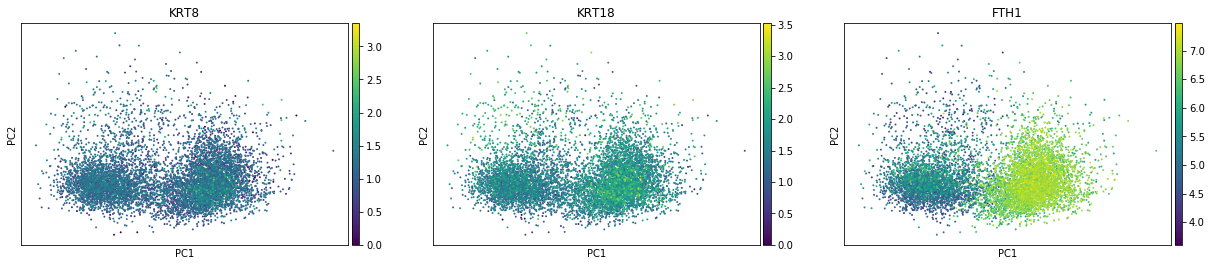

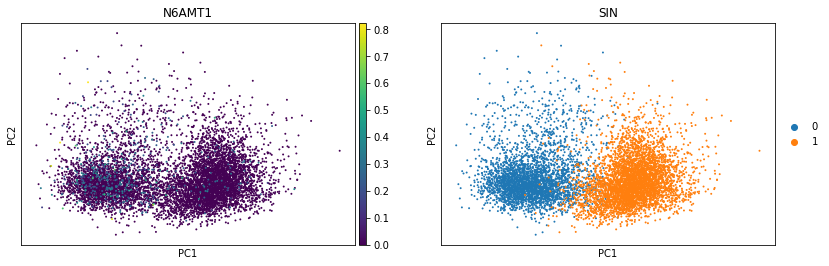

In [3]:
sc.tl.pca(ad_combi, svd_solver='arpack')
sc.pl.pca(ad_combi, color=['KRT8', 'KRT18', 'FTH1'])
sc.pl.pca(ad_combi, color=['N6AMT1','SIN'])

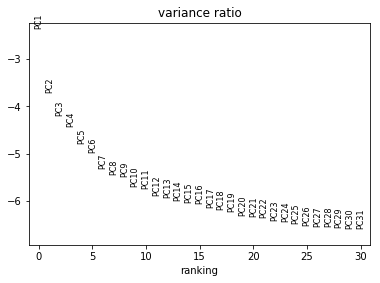

In [4]:
sc.pl.pca_variance_ratio(ad_combi, log=True)

Batch effect clearly in the first two components... we can see the variance drops at around 16 PCs.

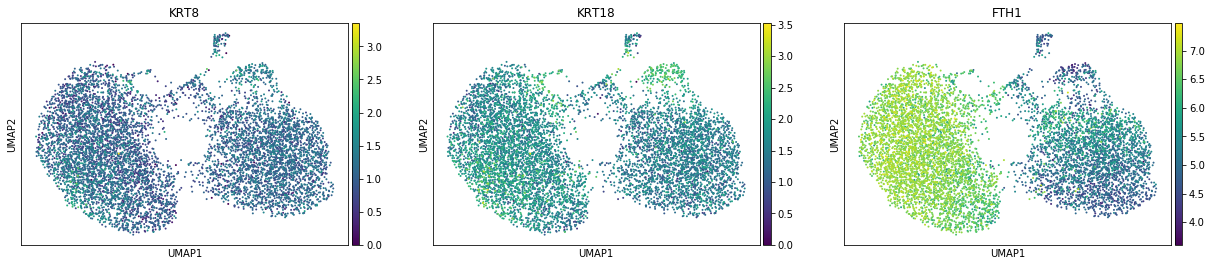

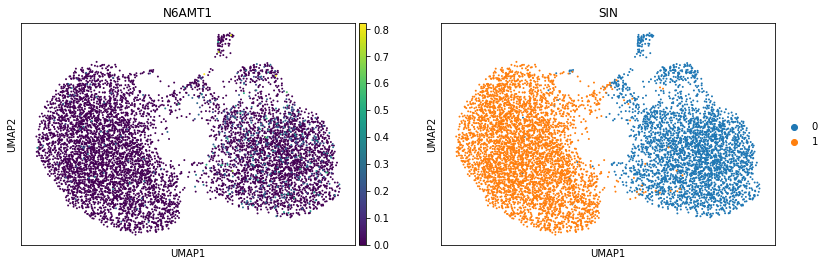

In [5]:
sc.pp.neighbors(ad_combi, n_neighbors=10, n_pcs=16)
sc.tl.umap(ad_combi)
sc.pl.umap(ad_combi, color=['KRT8', 'KRT18', 'FTH1'])
sc.pl.umap(ad_combi, color=['N6AMT1','SIN'])

Batch effect easily visible at 3 PCs

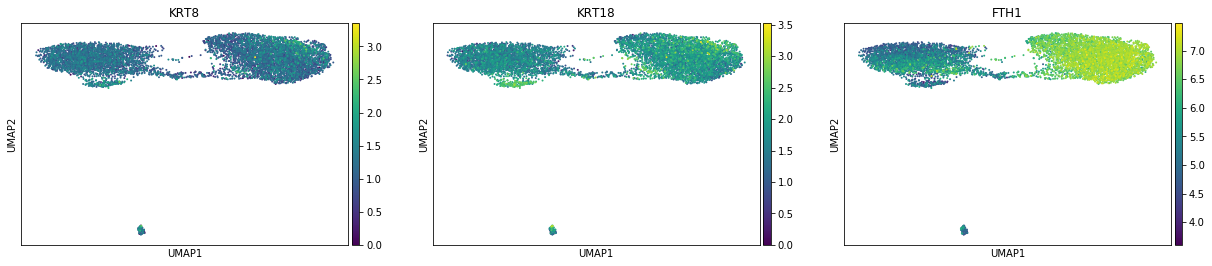

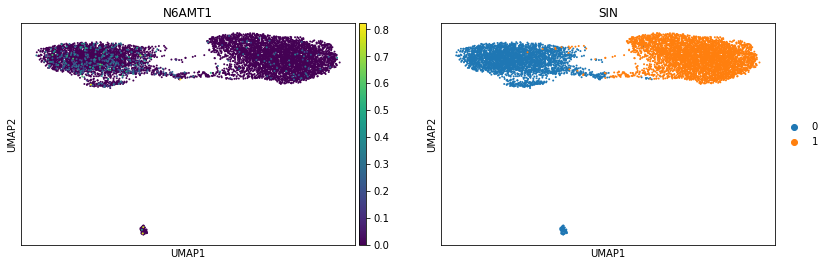

In [6]:
sc.pp.neighbors(ad_combi, n_neighbors=10, n_pcs=40)
sc.tl.umap(ad_combi)
sc.pl.umap(ad_combi, color=['KRT8', 'KRT18', 'FTH1'])
sc.pl.umap(ad_combi, color=['N6AMT1','SIN'])

Batch effect visible into the 40th PC.

It is *highly* unlikely this is due to differences related to cell cycle variation, but let's go ahead and try regardless.

# Cell Cycle Check



In [7]:
# Load cell cycle genes from Tirosh genes
cell_cycle_genes = [x.strip() for x in open('./sources/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

In [8]:
cell_cycle_genes_combi = [x for x in cell_cycle_genes if x in ad_combi.var_names]

In [9]:
sc.tl.score_genes_cell_cycle(ad_combi, s_genes=s_genes, g2m_genes=g2m_genes)

... storing 'phase' as categorical


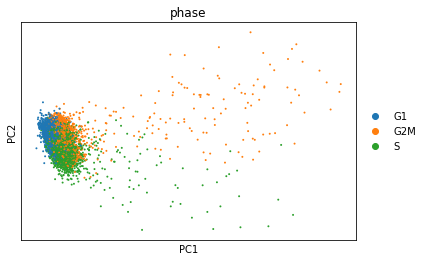

In [10]:
ad_combi_cc_genes = ad_combi[:, cell_cycle_genes_combi]
sc.tl.pca(ad_combi_cc_genes)
sc.pl.pca_scatter(ad_combi_cc_genes, color='phase')

The combined effect is reminiscent of the CTR in the seperate analysis, which is no doubt where most of the variation comes from. Let's regress these out.

... storing 'phase' as categorical


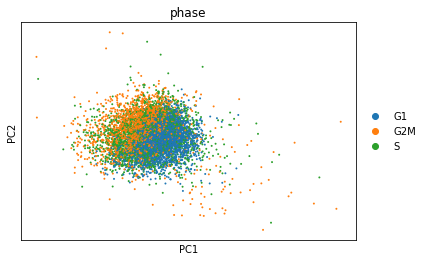

In [11]:
sc.pp.regress_out(ad_combi, ['S_score', 'G2M_score'])
sc.pp.scale(ad_combi)

ad_combi_cc_genes = ad_combi[:, cell_cycle_genes_combi]
sc.tl.pca(ad_combi_cc_genes)
sc.pl.pca_scatter(ad_combi_cc_genes, color='phase')

QUESTION: Why are we not regressing out G1?

Regressed. Let's see if it made any difference.


# PCA inspection with CC

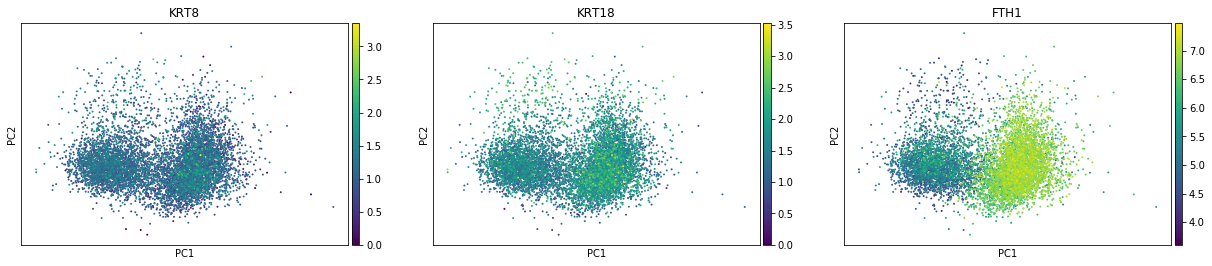

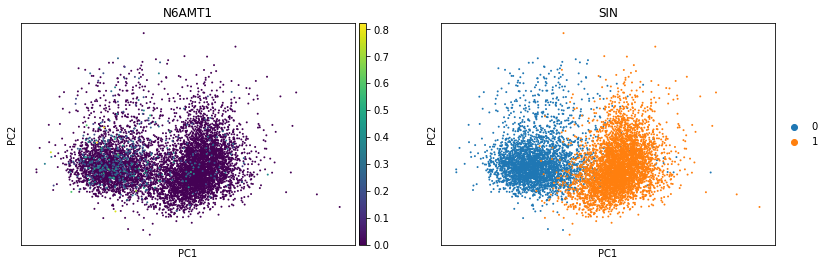

In [12]:
sc.tl.pca(ad_combi, svd_solver='arpack')
sc.pl.pca(ad_combi, color=['KRT8', 'KRT18', 'FTH1'])
sc.pl.pca(ad_combi, color=['N6AMT1','SIN'])

Nope, as expected.

Let's proceed and see what clusters we can detect.

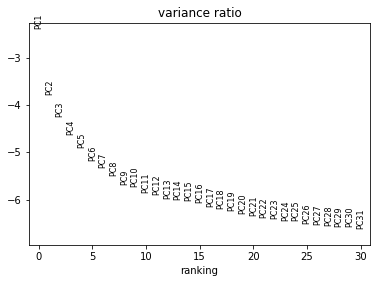

In [13]:
sc.pl.pca_variance_ratio(ad_combi, log=True)

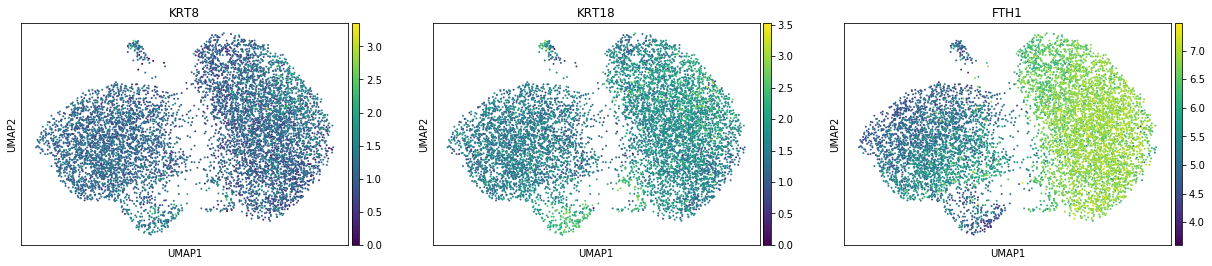

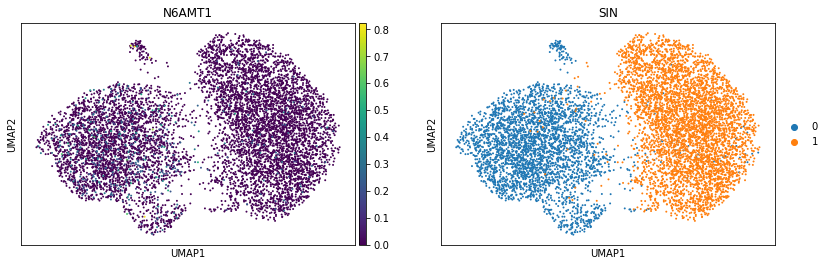

In [14]:
sc.pp.neighbors(ad_combi, n_neighbors=10, n_pcs=16)
sc.tl.umap(ad_combi)
sc.pl.umap(ad_combi, color=['KRT8', 'KRT18', 'FTH1'])
sc.pl.umap(ad_combi, color=['N6AMT1','SIN'])

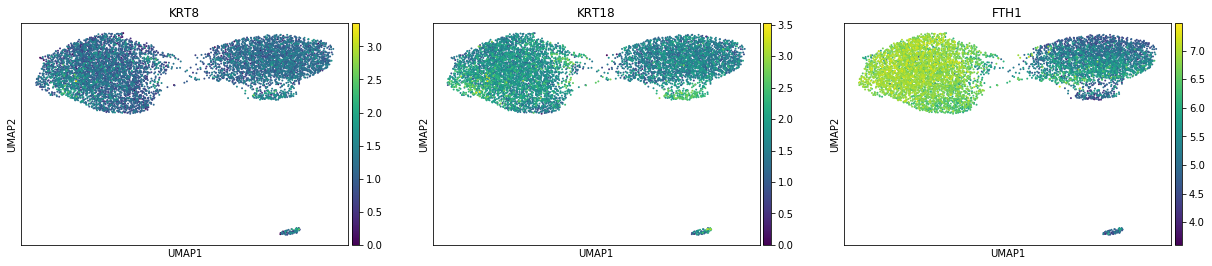

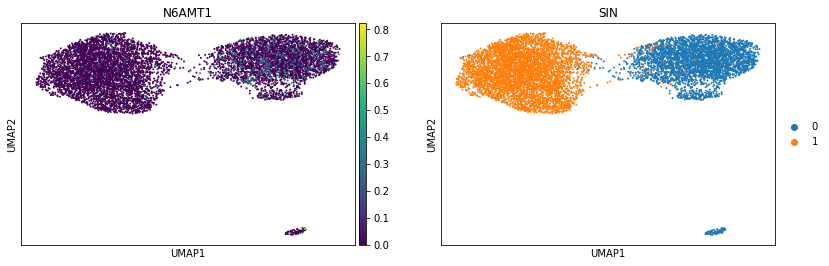

In [15]:
sc.pp.neighbors(ad_combi, n_neighbors=10, n_pcs=40)
sc.tl.umap(ad_combi)
sc.pl.umap(ad_combi, color=['KRT8', 'KRT18', 'FTH1'])
sc.pl.umap(ad_combi, color=['N6AMT1','SIN'])

Still persists at the 16 or 40 PCs. Let's do some clustering and see what the little island is.

In [16]:
sc.tl.louvain(ad_combi)

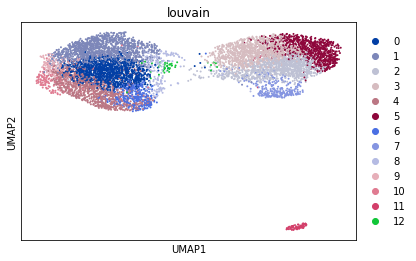

In [17]:
sc.pl.umap(ad_combi, color='louvain')

Some extreme clustering with some outliers. Let's see what is DE and see if cluster 11 is biologically relevant.

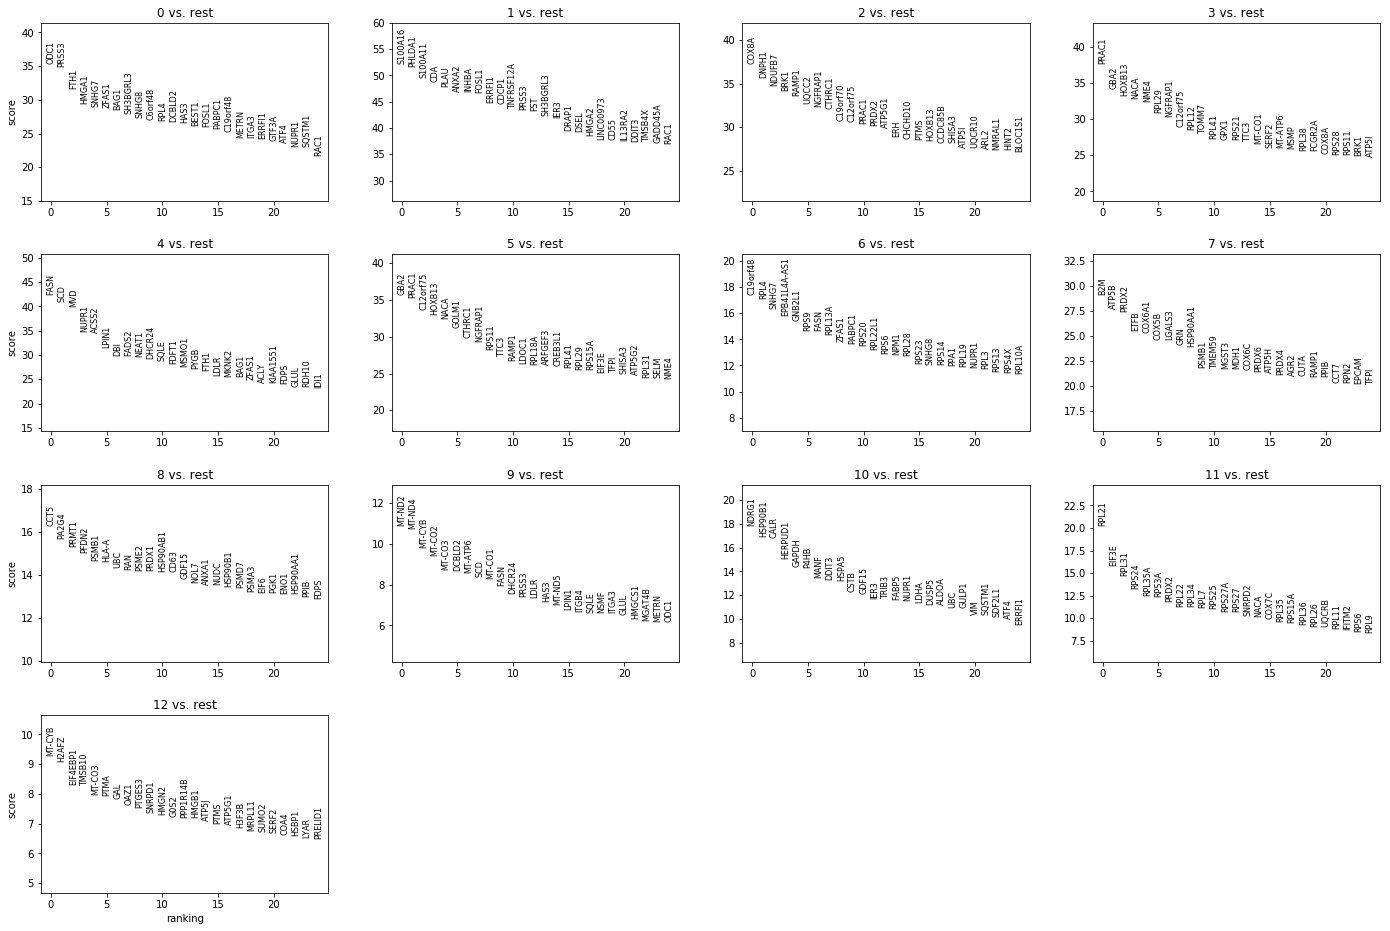

In [18]:
sc.tl.rank_genes_groups(ad_combi, 'louvain')
sc.pl.rank_genes_groups(ad_combi, n_genes=25, sharey=False)


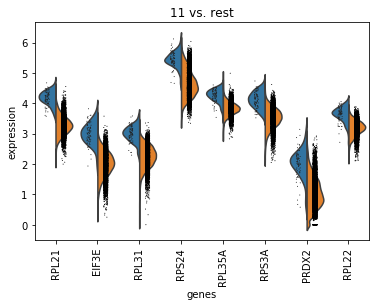

In [19]:
sc.pl.rank_genes_groups_violin(ad_combi, groups='11', n_genes=8)

We can clearly see that cluster 11 consists of Ribosomal Protein coding genes which do not appear anywhere else. EIF3E is a Eukaryotic Translation initiation factor, a requirement for protein synthesis related to the apoptotic pathway of fibroblasts.

We should remove this cluster.

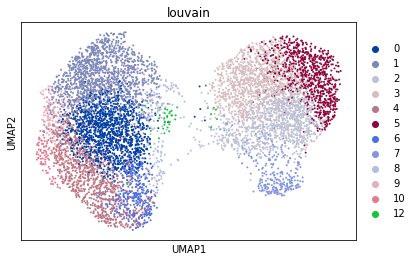

In [20]:
# Categorical data → Factors
ad_combi = ad_combi[ad_combi.obs["louvain"].astype('int64') != 11, :]
sc.pl.umap(ad_combi, color='louvain')

Let's also rerun the clustering.

In [29]:
sc.tl.louvain(ad_combi)

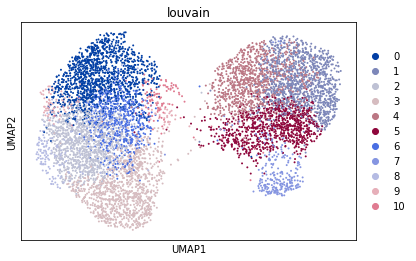

In [30]:
sc.pl.umap(ad_combi, color='louvain')

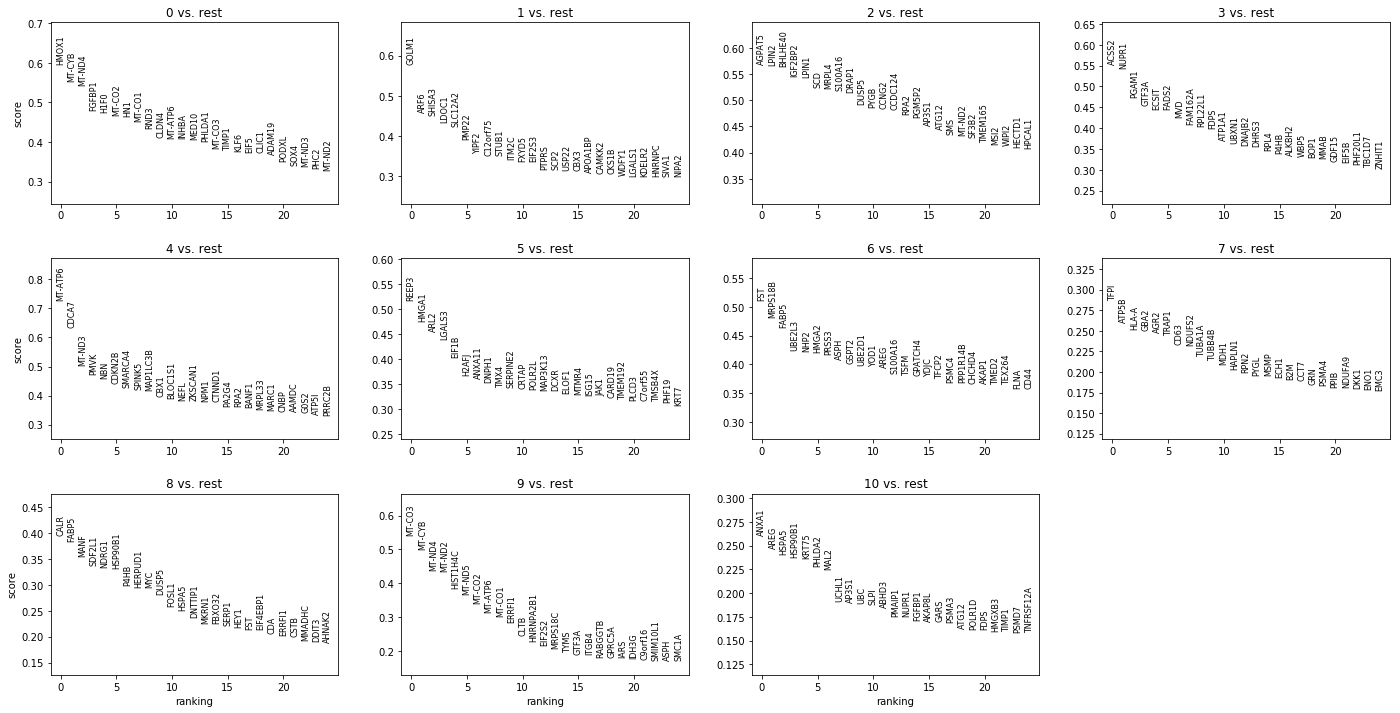

In [33]:
# Use logistic regression to determine groups.
sc.tl.rank_genes_groups(ad_combi, 'louvain', method="logreg")
sc.pl.rank_genes_groups(ad_combi, n_genes=25, sharey=False)

In [34]:
# Let's checkpoint.
ad_combi.write("checkpoints/scanpy.combi.cc.louvain.h5ad")

## Look for marker genes

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

ad_combi = sc.read("checkpoints/scanpy.combi.cc.louvain.h5ad")

Only considering the two last: ['.louvain', '.h5ad'].
Only considering the two last: ['.louvain', '.h5ad'].


In [10]:
markers = pd.read_csv("sources/Human_cell_markers.txt", sep='\t')
markers.head(5)

speciesType          tissueType UberonOntologyID cancerType     cellType  \
0       Human              Kidney   UBERON_0002113     Normal  Normal cell   
1       Human               Liver   UBERON_0002107     Normal  Normal cell   
2       Human         Endometrium   UBERON_0001295     Normal  Normal cell   
3       Human                Germ   UBERON_0000923     Normal  Normal cell   
4       Human  Corneal epithelium   UBERON_0001772     Normal  Normal cell   

                           cellName CellOntologyID  \
0             Proximal tubular cell            NaN   
1  Ito cell (hepatic stellate cell)     CL_0000632   
2                  Trophoblast cell     CL_0000351   
3              Primordial germ cell     CL_0000670   
4                   Epithelial cell     CL_0000066   

                        cellMarker geneSymbol geneID proteinName proteinID  \
0  Intestinal Alkaline Phosphatase       ALPI    248        PPBI    P09923   
1                    Synaptophysin        SYP   6855        SYPH    P08247   
2                          CEACAM1    CEACAM1    634       CEAM1    P13688   
3                             VASA       DDX4  54514        DDX4    Q9NQI0   
4                             KLF6       KLF6   1316        KLF6    Q99612   

  markerResource      PMID Company  
0     Experiment   9263997     NaN  
1     Experiment  10595912     NaN  
2     Experiment  10751340     NaN  
3     Experiment  10920202     NaN  
4     Experiment  12407152     NaN

Let's see how many Testis genes we can find and whether we should restrict ourselves to them only in this analysis.

In [256]:
#np.unique(sorted(markers["tissueType"))
markers[markers["tissueType"]=="Testis"]

speciesType tissueType UberonOntologyID                  cancerType  \
64         Human     Testis   UBERON_0000473                      Normal   
65         Human     Testis   UBERON_0000473                      Normal   
66         Human     Testis   UBERON_0000473                      Normal   
67         Human     Testis   UBERON_0000473                      Normal   
68         Human     Testis   UBERON_0000473                      Normal   
317        Human     Testis   UBERON_0000473                      Normal   
332        Human     Testis   UBERON_0000473                      Normal   
333        Human     Testis   UBERON_0000473                      Normal   
398        Human     Testis   UBERON_0000473                      Normal   
451        Human     Testis   UBERON_0000473  Testicular Germ Cell Tumor   
452        Human     Testis   UBERON_0000473  Testicular Germ Cell Tumor   
490        Human     Testis   UBERON_0000473                      Normal   
801        Human     Testis   UBERON_0000473                      Normal   
936        Human     Testis   UBERON_0000473                      Normal   
937        Human     Testis   UBERON_0000473                      Normal   
938        Human     Testis   UBERON_0000473                      Normal   
939        Human     Testis   UBERON_0000473                      Normal   
1745       Human     Testis   UBERON_0000473                      Normal   
1746       Human     Testis   UBERON_0000473                      Normal   
1747       Human     Testis   UBERON_0000473                      Normal   
1748       Human     Testis   UBERON_0000473                      Normal   
1749       Human     Testis   UBERON_0000473                      Normal   
1750       Human     Testis   UBERON_0000473                      Normal   
1751       Human     Testis   UBERON_0000473                      Normal   
1752       Human     Testis   UBERON_0000473                      Normal   
2674       Human     Testis   UBERON_0000473                      Normal   
2675       Human     Testis   UBERON_0000473                      Normal   

         cellType                  cellName CellOntologyID  \
64    Normal cell                  Gonocyte     CL_0000670   
65    Normal cell  Spermatogonial stem cell     CL_0000089   
66    Normal cell              Sertoli cell     CL_0000216   
67    Normal cell                  Gonocyte     CL_0000670   
68    Normal cell                  Gonocyte     CL_0000670   
317   Normal cell  Spermatogonial stem cell     CL_0000089   
332   Normal cell  Spermatogonial stem cell     CL_0000089   
333   Normal cell       Testis somatic cell     CL_0002371   
398   Normal cell            Spermatogonium     CL_0000020   
451   Cancer cell      Premeiotic germ cell     CL_0000586   
452   Cancer cell      Primordial germ cell     CL_0000670   
490   Normal cell  Spermatogonial stem cell     CL_0000089   
801   Normal cell              Sertoli cell     CL_0000216   
936   Normal cell               Leydig cell     CL_0000178   
937   Normal cell    Peritubular myoid cell     CL_0002481   
938   Normal cell              Sertoli cell     CL_0000216   
939   Normal cell  Spermatogonial stem cell     CL_0000089   
1745  Normal cell              Sertoli cell     CL_0000216   
1746  Normal cell              Sertoli cell     CL_0000216   
1747  Normal cell              Sertoli cell     CL_0000216   
1748  Normal cell               Leydig cell     CL_0000178   
1749  Normal cell               Leydig cell     CL_0000178   
1750  Normal cell                 Stem cell     CL_0000034   
1751  Normal cell                 Stem cell     CL_0000034   
1752  Normal cell                 Stem cell     CL_0000034   
2674  Normal cell  Spermatogonial stem cell     CL_0000089   
2675  Normal cell            Spermatogonium     CL_0000020   

                                  cellMarker  \
64                                    SSEA-4   
65                                    SSEA-

We are missing genes such as VIM, KRT8 and KRT18, so we need to broaden our search to include the full marker list.

In [236]:
class CellTypeFinder:
    markers = None
    
    @staticmethod
    def __populateMarkers():
        CellTypeFinder.markers = pd.read_csv("sources/Human_cell_markers.txt", sep='\t')
    
    
    def __init__(self, anndata, topN=15):
        self.df = anndata
        self.topN = topN

        
    def getCellTypeForCluster(self, cln, detected):
        mm = CellTypeFinder.markers
        res = mm[mm["geneSymbol"].isin(detected[str(cln)])].loc[:,["geneSymbol","cellMarker","cellName"]]
        res["cluster"] = cln
        return(res)

    
    def getCellTypesForAllClusters(self):
        
        if CellTypeFinder.markers is None:
            CellTypeFinder.__populateMarkers()
        
        detected = pd.DataFrame(self.df.uns['rank_genes_groups']['names']).head(self.topN)
        num_clusts = detected.columns.values.astype("int32").tolist()
    
        df = pd.DataFrame()
        res = df.append([self.getCellTypeForCluster(x, detected) for x in num_clusts])
        return(res.drop_duplicates())



### Regular Clustering

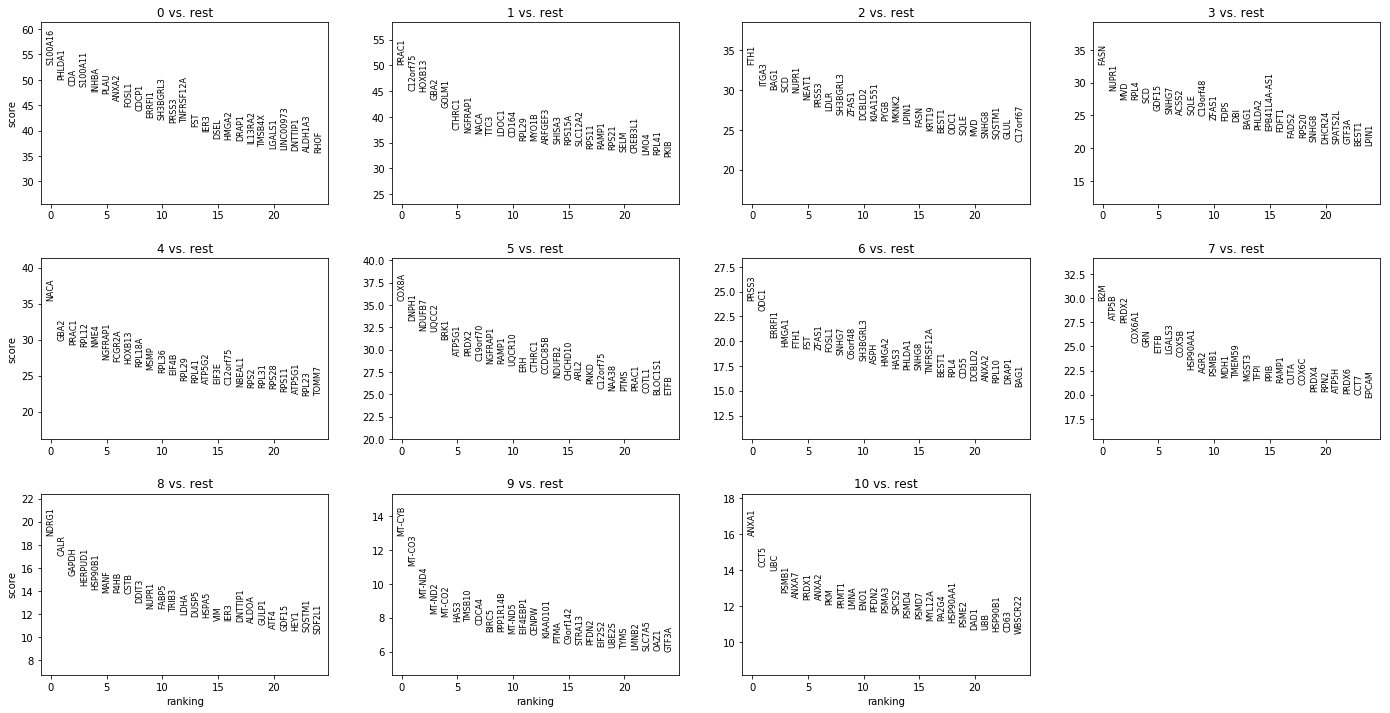

In [234]:
sc.tl.rank_genes_groups(ad_combi, 'louvain')
sc.pl.rank_genes_groups(ad_combi, n_genes=25, sharey=False)

In [237]:
# Top 8 genes in each of the 10 clusters
pd.DataFrame(ad_combi.uns['rank_genes_groups']['names']).head(8)

0         1      2      3        4         5       6       7  \
0  S100A16     PRAC1   FTH1   FASN     NACA     COX8A   PRSS3     B2M   
1   PHLDA1  C12orf75  ITGA3  NUPR1     GBA2     DNPH1    ODC1   ATP5B   
2      CDA    HOXB13   BAG1    MVD    PRAC1    NDUFB7  ERRFI1   PRDX2   
3  S100A11      GBA2    SCD   RPL4    RPL12     UQCC2   HMGA1  COX6A1   
4    INHBA     GOLM1  NUPR1    SCD     NME4      BRK1    FTH1     GRN   
5     PLAU    CTHRC1  NEAT1  GDF15  NGFRAP1    ATP5G1     FST    ETFB   
6    ANXA2   NGFRAP1  PRSS3  SNHG7   FCGR2A     PRDX2   ZFAS1  LGALS3   
7    FOSL1      NACA   LDLR  ACSS2   HOXB13  C19orf70   FOSL1   COX5B   

         8       9     10  
0    NDRG1  MT-CYB  ANXA1  
1     CALR  MT-CO3   CCT5  
2    GAPDH  MT-ND4    UBC  
3  HERPUD1  MT-ND2  PSMB1  
4  HSP90B1  MT-CO2  ANXA7  
5     MANF    HAS3  PRDX1  
6     P4HB  TMSB10  ANXA2  
7     CSTB   CDCA4    PKM

In [242]:
cd_combi = CellTypeFinder(ad_combi, 20)
cd_reg = cd_combi.getCellTypesForAllClusters()
cd_reg

geneSymbol                            cellMarker  \
707       CDCP1                                 CD318   
1727     PHLDA1                                PHLDA1   
258        PYGB  Brain isoform glycogen phosphorylase   
315       KRT19                        Cytokeratin-19   
353       KRT19                            Keratin-19   
1314       FASN                                   FAS   
1550      KRT19                                  CK19   
1960      KRT19                            Keratin-19   
2079      KRT19                        Cytokeratin-19   
1314       FASN                                   FAS   
1727     PHLDA1                                PHLDA1   
357      LGALS3                                 Gal-3   
440       FABP5                               PA-FABP   
1006      HSPA5                                 GRP78   
1360        VIM                              Vimentin   
1747        VIM                              Vimentin   
2078        VIM                              Vimentin   

                               cellName  cluster  
707                      Endocrine cell        0  
1727    Intestinal epithelial stem cell        0  
258               Liver progenitor cell        2  
315                     Epithelial cell        2  
353                    Cancer stem cell        2  
1314                        Cancer cell        2  
1550                        Cancer cell        2  
1960                    Progenitor cell        2  
2079            Luminal epithelial cell        2  
1314                        Cancer cell        3  
1727    Intestinal epithelial stem cell        6  
357                          Basal cell        7  
440   Epidermal transit amplifying cell        8  
1006                   Cancer stem cell        8  
1360                       Stromal cell        8  
1747                       Sertoli cell        8  
2078              Basal epithelial cell        8

### Rerun using log regression clustering



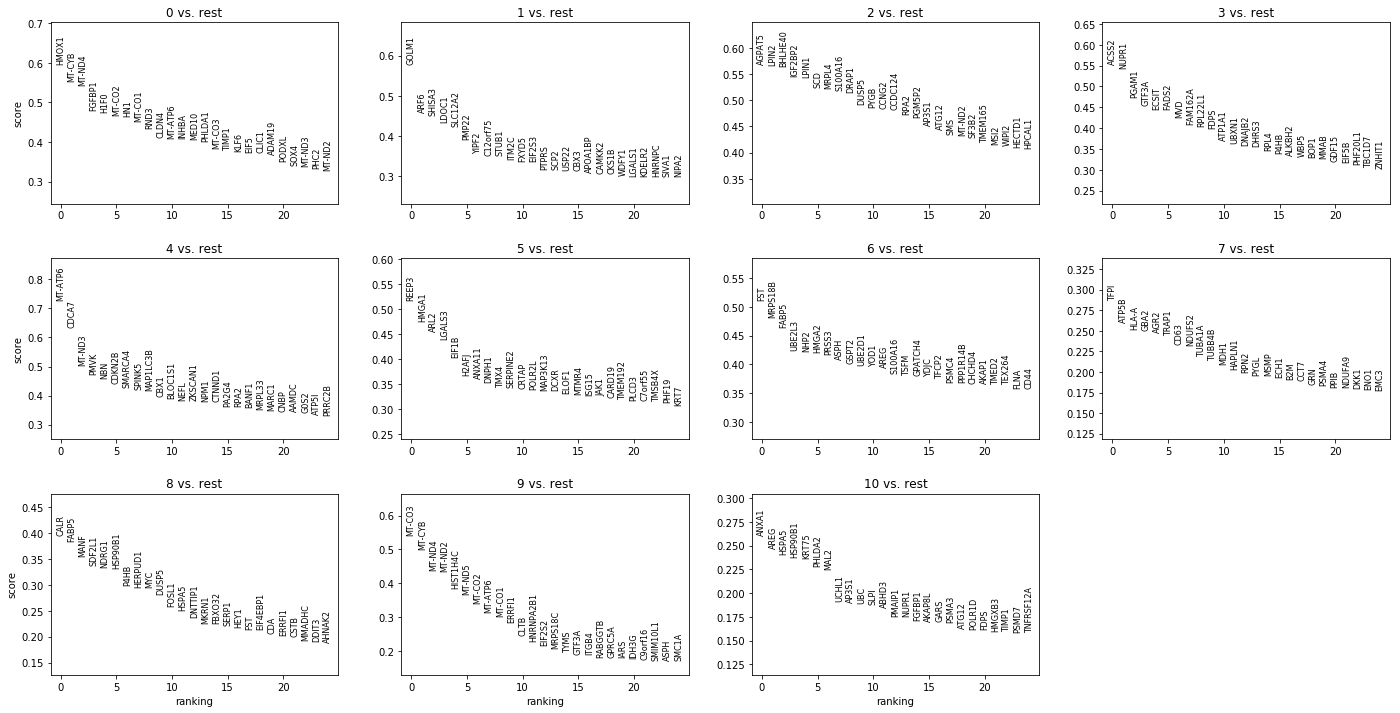

In [243]:
# Use logistic regression to determine groups.
sc.tl.rank_genes_groups(ad_combi, 'louvain', method="logreg")
sc.pl.rank_genes_groups(ad_combi, n_genes=25, sharey=False)

In [244]:
# Top 8 genes in each of the 10 clusters
pd.DataFrame(ad_combi.uns['rank_genes_groups']['names']).head(8)

0         1        2        3        4       5        6       7  \
0   HMOX1     GOLM1   AGPAT5    ACSS2  MT-ATP6   REEP3      FST    TFPI   
1  MT-CYB      ARF6    LPIN2    NUPR1    CDCA7   HMGA1  MRPS18B   ATP5B   
2  MT-ND4    SHISA3  BHLHE40    PGAM1   MT-ND3    ARL2    FABP5   HLA-A   
3  FGFBP1     LDOC1  IGF2BP2    GTF3A     PMVK  LGALS3   UBE2L3    GBA2   
4    H1F0   SLC12A2    LPIN1    ECSIT      NBN   EIF1B     NHP2    AGR2   
5  MT-CO2     PMP22      SCD    FADS2   CDKN2B   H2AFJ    HMGA2   TRAP1   
6     HN1     YIPF2    MRPL4      MVD  SMARCA4  ANXA11    PRSS3    CD63   
7  MT-CO1  C12orf75  S100A16  FAM162A   SPINK5   DNPH1     ASPH  NDUFS2   

         8         9       10  
0     CALR    MT-CO3    ANXA1  
1    FABP5    MT-CYB     AREG  
2     MANF    MT-ND4    HSPA5  
3   SDF2L1    MT-ND2  HSP90B1  
4    NDRG1  HIST1H4C    KRT75  
5  HSP90B1    MT-ND5   PHLDA2  
6     P4HB    MT-CO2     MAL2  
7  HERPUD1   MT-ATP6    UCHL1

In [245]:
cd_combi_log = CellTypeFinder(ad_combi, 20)
cd_log = cd_combi_log.getCellTypesForAllClusters()
cd_log

geneSymbol                            cellMarker  \
4          KLF6                                  KLF6   
1727     PHLDA1                                PHLDA1   
1668      USP22                                 USP22   
258        PYGB  Brain isoform glycogen phosphorylase   
542     BHLHE40                                  DEC1   
738     BHLHE40                                STRA13   
357      LGALS3                                 Gal-3   
440       FABP5                               PA-FABP   
1437       CD63                                  CD63   
440       FABP5                               PA-FABP   
1006      HSPA5                                 GRP78   
1006      HSPA5                                 GRP78   
1055      UCHL1                                 UCHL1   

                               cellName  cluster  
4                       Epithelial cell        0  
1727    Intestinal epithelial stem cell        0  
1668                   Cancer stem cell        1  
258               Liver progenitor cell        2  
542                       Decidual cell        2  
738                  Myoepithelial cell        2  
357                          Basal cell        5  
440   Epidermal transit amplifying cell        6  
1437                           Basophil        7  
440   Epidermal transit amplifying cell        8  
1006                   Cancer stem cell        8  
1006                   Cancer stem cell       10  
1055                             T cell       10

Let's compare them to the previous detected types.

In [247]:
cd_reg

geneSymbol                            cellMarker  \
707       CDCP1                                 CD318   
1727     PHLDA1                                PHLDA1   
258        PYGB  Brain isoform glycogen phosphorylase   
315       KRT19                        Cytokeratin-19   
353       KRT19                            Keratin-19   
1314       FASN                                   FAS   
1550      KRT19                                  CK19   
1960      KRT19                            Keratin-19   
2079      KRT19                        Cytokeratin-19   
1314       FASN                                   FAS   
1727     PHLDA1                                PHLDA1   
357      LGALS3                                 Gal-3   
440       FABP5                               PA-FABP   
1006      HSPA5                                 GRP78   
1360        VIM                              Vimentin   
1747        VIM                              Vimentin   
2078        VIM                              Vimentin   

                               cellName  cluster  
707                      Endocrine cell        0  
1727    Intestinal epithelial stem cell        0  
258               Liver progenitor cell        2  
315                     Epithelial cell        2  
353                    Cancer stem cell        2  
1314                        Cancer cell        2  
1550                        Cancer cell        2  
1960                    Progenitor cell        2  
2079            Luminal epithelial cell        2  
1314                        Cancer cell        3  
1727    Intestinal epithelial stem cell        6  
357                          Basal cell        7  
440   Epidermal transit amplifying cell        8  
1006                   Cancer stem cell        8  
1360                       Stromal cell        8  
1747                       Sertoli cell        8  
2078              Basal epithelial cell        8

Some consensus:
 * 0 : Intestinal Epithelial Cell
 * 2 : 

# Marker Gene Problem

I can't find the gene set they use for labelling their types.

EMT markers: 
* CDH1, VIM, CDH2, FN1 according to:
  * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3567921/  2013
* Epithelial-Mesenchymal transitioning cells, where they lose their cell adhesion and polarity and go wandering.
* They are essentially multipotent stromal cells (can diff into fibroblasts and pericytes, both structural.)
* However their analysis uses: VIM, CD59, SERPINE2, TNFRSF12A


OXPHOS markers: 
* mitochondrial genes? Should these *not* be filtered/capped?
* Oxidative phosphorlyation.
* A mitochondrial system related to ATP for powering the cell
* According to Table1 of https://www.biorxiv.org/content/10.1101/136457v1.supplementary-material, there are 96 of them, which I have saved in sources/oxphos.genes

Glycolysis Score:
* Could not find much in the literature, so I downloaded 27 genes from http://amigo.geneontology.org/amigo/search/bioentity by searching for 'glycolysis'. It is saved in sources/glycolysis.genes 

TODO:
 * Do an individual score of EMT, OXPHOS, and Glyco on the seperate anaylsis and see if you can find the same expression levels they do
    * Do individual clustering first.
 * Integrated analysis using CCA or PyScenic -- https://github.com/theislab/scanpy/issues/265
